# Droop Parameter Sweep

In [1]:
; cd ..

/Users/rhenriquez/Github_Projects/InverterDynamicLinesModels


In [2]:
] activate

 Activating environment at `~/Github_Projects/InverterDynamicLinesModels/Project.toml`


In [3]:
] instantiate

In [4]:
using OrdinaryDiffEq #Gets the solvers
using Plots
include(joinpath(pwd(), "InverterDynamicLinesModels", "InverterDynamicLinesModels.jl"))

In [5]:
using PowerSystems

In [6]:
# Load Data with PF solution from file
omib_sys = System(joinpath(pwd(), "data", "OMIB_inverter.json"));

┌ Info: Loaded time series from storage file existing=OMIB_inverter_time_series_storage.h5 new=/var/folders/fz/6cnhcl5n2dggz6f6c_l54g740000gn/T/jl_PpFkk1
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/uydla/src/hdf5_time_series_storage.jl:72
┌ Warning: There are no Generator Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56
┌ Warning: There are no ElectricLoad Components in the System
└ @ PowerSystems /Users/rhenriquez/.julia/packages/PowerSystems/Ihfxp/src/utils/IO/system_checks.jl:56


## Parameter Sweep `kp` and `kq`: Kiwi line 100 km, N = 50, p = 1.0

In [38]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [39]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0;

In [40]:
N = 75
res = Matrix{Complex}(undef, N, 5*N)
damp = Matrix{Float64}(undef, N, 5*N)
p_fact = Array{Float64}(undef, (N, 5*N, 19))
damp_crit = Vector{Float64}(undef, N)
kq_crit = Vector{Float64}(undef, N)
p_fact_crit = Matrix{Float64}(undef, N, 19)
eig_crit = Vector{Complex}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 10, length = 5*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig
        damp[i, j] = round(ss_vsm.damping_vector[end], digits = 4)
        p_fact[i, j, :] = round.(ss_vsm.participation_factors[:, end], digits = 4)
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit[i] = -1
        damp_crit[i] = damp[i, 1]
        p_fact_crit[i, :] = p_fact[i, 1, :]
    else
        idx_crit = idx[1]
        eig_crit[i] = res[i, idx_crit]
        kq_crit[i] = round(kq_range[idx_crit], digits = 4)
        damp_crit[i] = damp[i, idx_crit]
        p_fact_crit[i, :] = p_fact[i, idx_crit, :]
    end
end 

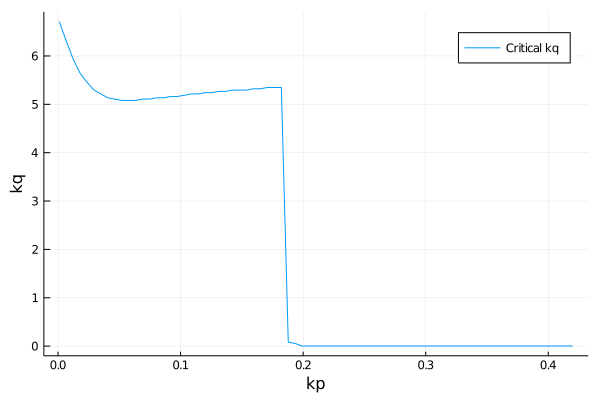

In [41]:
plot(kp_range, kq_crit, label="Critical kq", xlabel = "kp", ylabel = "kq")

### Algebraic Lines

In [42]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, StaticLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, StaticLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [43]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0;

In [44]:
N = 75
res = Matrix{Complex}(undef, N, 5*N)
damp_alg = Matrix{Float64}(undef, N, 5*N)
p_fact_alg = Array{Float64}(undef, (N, 5*N, 13))
damp_crit_alg = Vector{Float64}(undef, N)
p_fact_crit_alg = Matrix{Float64}(undef, N, 13)
eig_crit_alg = Vector{Complex}(undef, N)
kq_crit_alg = Vector{Float64}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 20, length = 5*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig     
        damp_alg[i, j] = round(ss_vsm.damping_vector[end], digits = 4)
        p_fact_alg[i, j, :] = round.(ss_vsm.participation_factors[:, end], digits = 4)
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit_alg[i] = -1
        damp_crit_alg[i] = damp_alg[i, 2] #Store for kq = 0.02
        p_fact_crit_alg[i, :] = p_fact_alg[i, 2, :]
    else
        idx_crit = idx[1]
        eig_crit_alg[i] = res[i, idx_crit]
        kq_crit_alg[i] = round(kq_range[idx_crit], digits = 4)
        damp_crit_alg[i] = damp_alg[i, idx_crit]
        p_fact_crit_alg[i, :] = p_fact_alg[i, idx_crit, :]
    end
end 

### AC Static

In [45]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [46]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[10] = 1.0;

In [47]:
N = 75
res = Matrix{Complex}(undef, N, 7*N)
damp_st = Matrix{Float64}(undef, N, 7*N)
p_fact_st = Array{Float64}(undef, (N, 7*N, 7))
damp_crit_st = Vector{Float64}(undef, N)
p_fact_crit_st = Matrix{Float64}(undef, N, 7)
eig_crit_st = Vector{Complex}(undef, N)
kq_crit_st = Vector{Float64}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 20, length = 7*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig
        damp_st[i, j] = round(ss_vsm.damping_vector[end], digits = 4)
        p_fact_st[i, j, :] = round.(ss_vsm.participation_factors[:, end], digits = 4)
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit_st[i] = 25
        damp_crit_st[i] = damp_st[i, 2] #Store for kq = 0.02
        p_fact_crit_st[i, :] = p_fact_st[i, 2, :]
    else
        idx_crit = idx[1]
        eig_crit_st[i] = res[i, idx_crit]
        kq_crit_st[i] = round(kq_range[idx_crit], digits = 4)
        damp_crit_st[i] = damp_st[i, idx_crit]
        p_fact_crit_st[i, :] = p_fact_st[i, idx_crit, :]
    end
end 

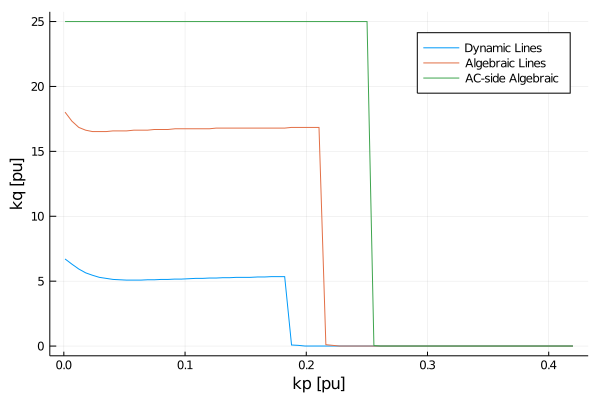

In [48]:
plot(kp_range, kq_crit, label = "Dynamic Lines")
plot!(kp_range, kq_crit_alg, label= "Algebraic Lines")
plot!(kp_range, kq_crit_st, label= "AC-side Algebraic")
plot!(xlabel="kp [pu]")
plot!(ylabel="kq [pu]")

## Parameter Sweep `kp` and `kq`: Kiwi line 100 km, N = 100, p_ref = 0.5

In [49]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, DynamicLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, DynamicLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [50]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[32] = 100 * 2.75;

In [51]:
N = 75
res = Matrix{Complex}(undef, N, 5*N)
kq_crit = Vector{Float64}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 10, length = 5*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit[i] = -1
    else
        idx_crit = idx[1]
        kq_crit[i] = round(kq_range[idx[1]], digits = 4)
    end
end 

In [52]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, StaticLines, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, StaticLines);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [53]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[32] = 100 * 2.75;

In [54]:
N = 75
res = Matrix{Complex}(undef, N, 5*N)
kq_crit_alg = Vector{Float64}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 25, length = 5*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit_alg[i] = -1
    else
        idx_crit = idx[1]
        kq_crit_alg[i] = round(kq_range[idx[1]], digits = 4)
    end
end 

In [55]:
#Instantiate Parameters for VSM model
parameter_mapping = instantiate_parameters(VInertia, omib_sys)
M_vsm = instantiate_model(VInertia, ACStatic, omib_sys)
u0 = M_vsm(parameter_mapping) # works as a test, not really necessary to call
jac_exp_vsm = get_jacobian_function(VInertia, ACStatic);
fjac_vsm = eval(jac_exp_vsm);
jac_vsm = instantiate_jacobian(M_vsm, fjac_vsm)
ss_vsm = instantiate_small_signal(M_vsm, jac_vsm)
ss_vsm(M_vsm, jac_vsm)

In [56]:
# Create Parameter Vector to modify it later
parameter_values = [x.second for x in parameter_mapping];
parameter_values[32] = 100 * 2.75;

In [57]:
N = 75
res = Matrix{Complex}(undef, N, 5*N)
kq_crit_st = Vector{Float64}(undef, N)
kp_range = range(0.001, 0.42, length = N)
kq_range = range(0.001, 25, length = 5*N)
for (i, kpval) in enumerate(kp_range)
    parameter_values[21] = kpval
    for (j, kqval) in enumerate(kq_range)
        parameter_values[22] = kqval
        M_vsm(parameter_values)
        jac_vsm(M_vsm)
        ss_vsm(M_vsm, jac_vsm)
        eig = ss_vsm.eigen_vals[end]
        res[i, j] = eig
    end
    idx = findall(x -> real(x) >= 0, res[i, :]);
    if isempty(idx)
        kq_crit_st[i] = 25
    else
        idx_crit = idx[1]
        kq_crit_st[i] = round(kq_range[idx[1]], digits = 4)
    end
end 

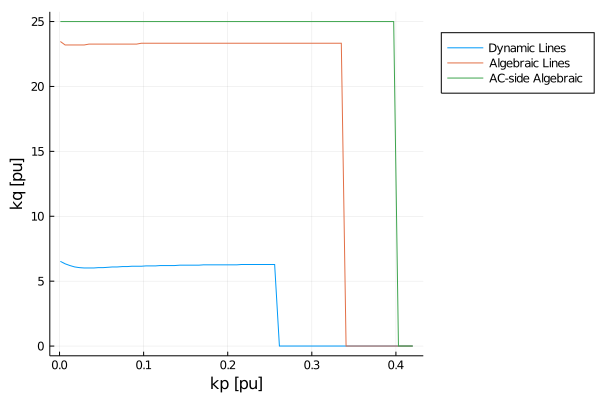

In [58]:
plot(kp_range, kq_crit, label = "Dynamic Lines")
plot!(kp_range, kq_crit_alg, label= "Algebraic Lines")
plot!(kp_range, kq_crit_st, label= "AC-side Algebraic", legend=:outertopright)
plot!(xlabel="kp [pu]")
plot!(ylabel="kq [pu]")